In [45]:
import os
import re

import numpy as np
import tensorflow as tf

np.random.seed(1)
tf.random.set_seed(2)

import pandas as pd
import keras
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, classification_report, log_loss

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Flatten
from keras.layers import Dropout, Conv1D, GlobalMaxPool1D, GRU, GlobalAvgPool1D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

print(os.listdir('../LSTM'))

['model_1b.h5', 'model_1c.h5', 'text.csv', 'Sentiment.csv', 'LSTM-B-OnlyText.ipynb', 'LearnPipeline.ipynb', 'model_1.h5', 'glove.840B.300d.txt', 'PA-all.csv', 'model_2.h5', 'LSTM-B.ipynb', 'model.hdf5', 'glove.twitter.27B.200d.txt', '.ipynb_checkpoints', 'LSTM-B-AllFeatures.ipynb', 'PA-Truth.csv', 'model_1d.h5']


In [46]:
MAX_SEQ_LEN = 25 #this is based on a quick analysis of the len of sequences train['text'].apply(lambda x : len(x.split(' '))).quantile(0.95)
DEFAULT_BATCH_SIZE = 64

In [47]:
data = pd.read_csv('PA-all.csv')

data['A1']=data['A1'].astype("category")
data['A2']=data['A2'].astype("category")
data['A3']=data['A3'].astype("category")
data['sex']=data['sex'].astype("category")
data['age']=data['age'].astype("category")
data['org']=data['org'].astype("category")
data['truth']=data['truth'].astype("category")
data.head()


#data['truth']=np.where(data['truth'] ==1, 'YY', data['truth'])
data['truth']=np.where(data['truth'] ==2, '0', data['truth'])
data['truth']=np.where(data['truth'] =='3', '0', data['truth'])
data['truth']=np.where(data['truth'] =='4', '0', data['truth'])
data['truth']=np.where(data['truth'] =='5', '0', data['truth'])

data.head()
# data = data[data['sentiment'] != 'Neutral']
train, test = train_test_split(data, random_state = 42, test_size=0.2)
print(train.shape)
print(test.shape)

(2662, 8)
(666, 8)


In [48]:
CONTRACTION_MAPPING = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                       "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                       "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                       "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                       "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                       "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                       "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                       "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
                       "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
                       "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                       "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                       "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are",
                       "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have",
                       "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
                       "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                       "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have",
                       "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
                       "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have",
                       "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would",
                       "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have",
                       "It's": 'It is', "Can't": 'Can not', "I've": 'I have' }

In [49]:
data.head()

,A1,A2,A3,truth,age,sex,org,text
0,3,4,4,0,>=40,female,non-org,I ran out of coffee. Is it socially acceptable...
1,1,4,4,1,19-29,male,non-org,For anyone who doesn't think golf is a real sp...
2,1,1,4,1,19-29,male,non-org,This hurts to read. I've had to snowline chase...
3,3,3,3,0,19-29,male,non-org,There is an elderly couple cross country skiin...
4,1,1,1,1,30-39,female,non-org,Morning workout at PureFX @purefxfitness I rea...


In [50]:
def clean_text(text, mapping):
    replace_white_space = ["\n"]
    for s in replace_white_space:
        text = text.replace(s, " ")
    replace_punctuation = ["’", "‘", "´", "`", "\'", r"\'"]
    for s in replace_punctuation:
        text = text.replace(s, "'")
    
    # Random note: removing the URL's slightly degraded performance, it's possible the model learned that certain URLs were positive/negative
    # And was able to extrapolate that to retweets. Could also explain why re-training the Embeddings improves performance.
    # remove twitter url's
#     text = re.sub(r"http[s]?://t.co/[A-Za-z0-9]*","TWITTERURL",text)
    mapped_string = []
    for t in text.split(" "):
        if t in mapping:
            mapped_string.append(mapping[t])
        elif t.lower() in mapping:
            mapped_string.append(mapping[t.lower()])
        else:
            mapped_string.append(t)
    return ' '.join(mapped_string)

In [51]:

# CONTRACTION_MAPPING is a map of common contractions(e.g don't => do not)
train_text_vec = [clean_text(text, CONTRACTION_MAPPING) for text in train['text'].values]
test_text_vec = [clean_text(text, CONTRACTION_MAPPING) for text in test['text'].values]


# tokenize the sentences
tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(train_text_vec)
train_text_vec = tokenizer.texts_to_sequences(train_text_vec)
test_text_vec = tokenizer.texts_to_sequences(test_text_vec)

# pad the sequences
train_text_vec = pad_sequences(train_text_vec, maxlen=MAX_SEQ_LEN)
test_text_vec = pad_sequences(test_text_vec, maxlen=MAX_SEQ_LEN)

print('Number of Tokens:', len(tokenizer.word_index))
print("Max Token Index:", train_text_vec.max(), "\n")

print('Sample Tweet Before Processing:', train["text"].values[0])
print('Sample Tweet After Processing:', tokenizer.sequences_to_texts([train_text_vec[0]]), '\n')

print('What the model will interpret:', train_text_vec[0].tolist())

Number of Tokens: 13064
Max Token Index: 13064 

Sample Tweet Before Processing: I finished my first half marathon, now what are you going to do?!?! 🏃🏽‍♀️💨Rollerskate!!!! That’s what! ⛸🤩🛹… https://t.co/ao7LbQ7hOz
Sample Tweet After Processing: ['I finished my first half marathon now what are you going to do 🏃🏽\u200d♀️💨Rollerskate that is what ⛸🤩🛹… https t co ao7LbQ7hOz'] 

What the model will interpret: [0, 0, 0, 7, 228, 13, 48, 342, 732, 29, 111, 31, 19, 66, 6, 34, 3430, 33, 9, 111, 3431, 3, 1, 2, 3432]


In [52]:
train[['text', 'A1']]

,text,A1
3125,"I finished my first half marathon, now what ar...",4
2328,I’m a technical wrestler now💁🏻‍♀️\n\nfemmesfat...,1
56,@shay7t Thank you for teaching me everything t...,4
1988,Nov 18 - 2017\n\nOpening\n\nThe first cheque I...,2
1814,Fighting Stigma : Irish boy dies after Spanish...,4
...,...,...
1095,Started today with a fantastic #strength worko...,1
1130,#lastday15x5workout for 4-6 weeks (depends on ...,1
1294,Staying active during covid. In home workouts...,1
860,Hoping to run 32-36km tomorrow and can’t see m...,1


In [53]:
encoder = LabelEncoder()

y_train = encoder.fit_transform(train['truth'].values)
y_train = to_categorical(y_train) 

y_test = encoder.fit_transform(test['truth'].values)
y_test = to_categorical(y_test) 

In [54]:
# get an idea of the distribution of the text values
from collections import Counter
ctr = Counter(train['truth'].values)
print('Distribution of Classes:', ctr)

# get class weights for the training data, this will be used data
y_train_int = np.argmax(y_train,axis=1)
cws = class_weight.compute_class_weight('balanced', np.unique(y_train_int), y_train_int)
print(cws)

Distribution of Classes: Counter({'0': 1604, '1': 1058})
[0.8298 1.258 ]


/Users/zahrashakeri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass classes=[0 1], y=[1 1 1 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [55]:
# 
print('Dominant Class: ', ctr.most_common(n = 1)[0][0])
print('Baseline Accuracy Dominant Class', (ctr.most_common(n = 1)[0][0] == test['truth'].values).mean())

preds = np.zeros_like(y_test)
preds[:, 0] = 1
preds[0] = 1 #done to suppress warning from numpy for f1 score
print('F1 Score:', f1_score(y_test, preds, average='weighted'))

Dominant Class:  0
Baseline Accuracy Dominant Class 0.5645645645645646
F1 Score: 0.41043275303322385


In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

np.set_printoptions(precision=4)
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    # Compute confusion matrix
    classes = classes[unique_labels(y_true, y_pred)]
    _cm = confusion_matrix(y_true, y_pred)

    print(classification_report(y_true, y_pred, target_names=classes))
        
    def _build_matrix(fig, ax, cm, normalize = False):
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        im = ax.imshow(cm, cmap=cmap)
#         fig.colorbar(im, ax=ax)
        
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=classes, 
               yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        
    fig, [ax1, ax2] = plt.subplots(nrows = 1, ncols = 2, figsize=(8, 4))
    _build_matrix(fig, ax1, cm = _cm, normalize=False)
    _build_matrix(fig, ax2, cm = _cm, normalize=True)
    fig.tight_layout()

Baseline Accuracy Using Naive Bayes:  0.6666666666666666
F1 Score: 0.6107048627004418
              precision    recall  f1-score   support

           0       0.63      0.98      0.77       376
           1       0.90      0.26      0.41       290

    accuracy                           0.67       666
   macro avg       0.77      0.62      0.59       666
weighted avg       0.75      0.67      0.61       666



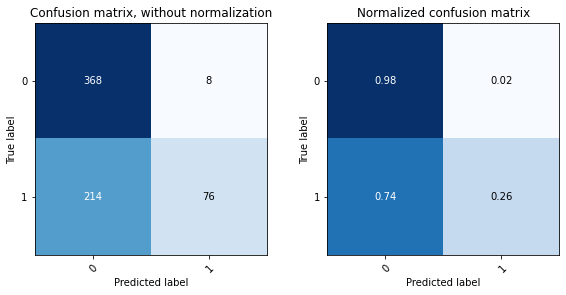

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
text_clf.fit(tokenizer.sequences_to_texts_generator(train_text_vec), y_train.argmax(axis=1))
predictions = text_clf.predict(tokenizer.sequences_to_texts_generator(test_text_vec)) 
print('Baseline Accuracy Using Naive Bayes: ', (predictions == y_test.argmax(axis = 1)).mean())
print('F1 Score:', f1_score(y_test.argmax(axis = 1), predictions, average='weighted'))

_ = plot_confusion_matrix(y_test.argmax(axis = 1), predictions, classes=encoder.classes_, title='Confusion matrix, without normalization')

In [58]:
def threshold_search(y_true, y_proba, average = None):
    best_threshold = 0
    best_score = 0
    for threshold in [i * 0.01 for i in range(100)]:
        score = f1_score(y_true=y_true, y_pred=y_proba > threshold, average=average)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result


def train(model, 
          X_train, y_train, X_test, y_test, 
          
          checkpoint_path='model.hdf5', 
          epcohs = 25, 
          batch_size = DEFAULT_BATCH_SIZE, 
          class_weights = None, 
          fit_verbose=2,
          print_summary = True
         ):
    m = model()
    if print_summary:
        print(m.summary())
    m.fit(
        X_train, 
        y_train, 
        #this is bad practice using test data for validation, in a real case would use a seperate validation set
        validation_data=(X_test, y_test),  
        epochs=epcohs, 
        batch_size=batch_size,
        class_weight=class_weights,
         #saves the most accurate model, usually you would save the one with the lowest loss
        callbacks= [
            ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True),
            EarlyStopping(patience = 2)
        ],
        verbose=fit_verbose
    ) 
    print("\n\n****************************\n\n")
    print('Loading Best Model...')
    m.load_weights(checkpoint_path)
    predictions = m.predict(X_test, verbose=1)
    print('Validation Loss:', log_loss(y_test, predictions))
    print('Test Accuracy', (predictions.argmax(axis = 1) == y_test.argmax(axis = 1)).mean())
    print('F1 Score:', f1_score(y_test.argmax(axis = 1), predictions.argmax(axis = 1), average='weighted'))
    plot_confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1), classes=encoder.classes_)
    plt.show()    
    return m #returns best performing model

-*******-- <class 'numpy.ndarray'>
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 128)           1672320   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 1,812,290
Trainable params: 1,812,290
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25

Epoch 00001: val_accuracy improved from -inf to 0.72823, saving model to model_1.h5
42/42 - 3s - loss: 0.6633 - accuracy: 0.5808 - val_loss: 0.5795 - val_accuracy: 0.7282
Epoch 2/25

Epoch 000

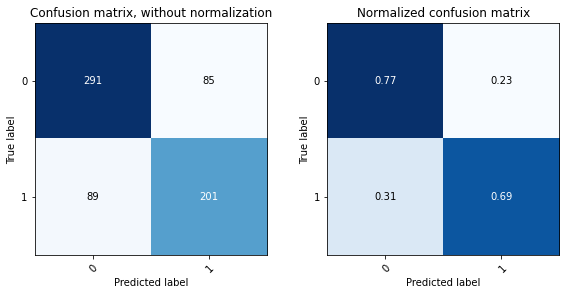

In [59]:
def model_1():
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    model.add(LSTM(128))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
print("-*******--",type(cws))
m1 = train(model_1, 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           checkpoint_path='model_1.h5',
           class_weights={i : cws[i] for i in range(2)}
          )

In [60]:
train_text_vec

array([[    0,     0,     0, ...,     1,     2,  3432],
       [    0,     0,     0, ...,     1,     2,  3439],
       [    0,     0,     0, ...,  3442,  3443,  3444],
       ...,
       [    0,     0,     0, ...,    13,   257,   662],
       [    0,     0,  3369, ...,  1065, 13063, 13064],
       [    0,     0,     0, ...,   138,    27,    20]], dtype=int32)

In [ ]:
def model_1():
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    model.add(LSTM(128))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

m1 = train(model_1, 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           checkpoint_path='model_1.h5',
           class_weights={i : cws[i] for i in range(2)}
          )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 25, 128)           1672320   
_________________________________________________________________
dropout (Dropout)            (None, 25, 128)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 1,952,066
Trainable params: 1,952,066
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25

Epoch 00001: val_accuracy improved from -inf to 0.73874, saving model to model_1b.h5
42/42 - 

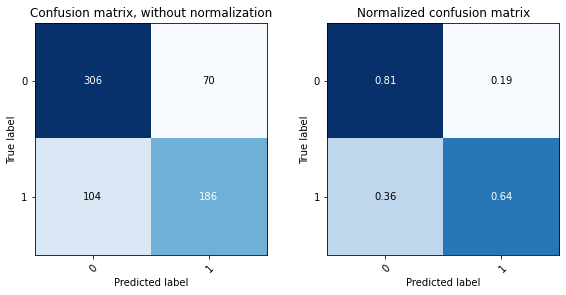

In [62]:
  def model_1b():
    """
    Using a Bidiretional LSTM. 
    """
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25)))
    model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.3))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

_ = train(model_1b, 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           checkpoint_path='model_1b.h5',
           class_weights={i : cws[i] for i in range(2)},
           print_summary = True
          )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 25, 128)           1672320   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 25, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 25, 256)           263168    
_________________________________________________________________
conv1d (Conv1D)              (None, 22, 64)            65600     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

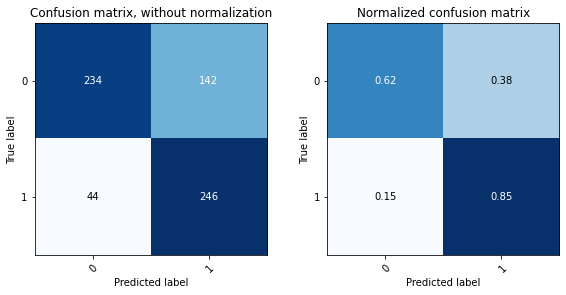

In [63]:
def model_1c():
    """
    Adding dropout to reduce overfitting using a bidiretional LSTM
    """
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)))
    model.add(Conv1D(64, 4))
#     model.add(Flatten())
    model.add(GlobalMaxPool1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     print(model.summary())
    return model


_ = train(model_1c, 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           checkpoint_path='model_1c.h5',
           class_weights={i : cws[i] for i in range(2)},
           print_summary = True
          )

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 25, 128)           1672320   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 25, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 21, 64)            41024     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 19, 64)            12352     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 18, 64)            8256      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

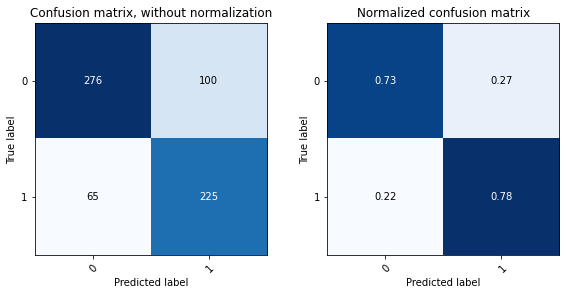

In [64]:
def model_1d():
    """
    Just for fun below is a model only using covolutions. This is pretty good and also trains very quickly(and predictions would also likely be fast) compared to the LSTM...
    It's equivalent to using an n-gram based approach.
    Usually in practice you would use a more complex architecture with multiple parallel convolutions that are combined before pooling(and usually both max and avg).
    Pure Convolutional NLP is definitely a solution worth exploring further.
    """
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    model.add(SpatialDropout1D(0.3))
    model.add(Conv1D(64, 5))
    model.add(Conv1D(64, 3))
    model.add(Conv1D(64, 2))
    model.add(GlobalMaxPool1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


_ = train(model_1d, 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           checkpoint_path='model_1d.h5',
           class_weights={i : cws[i] for i in range(2)},
           print_summary = True
          )

In [65]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

def get_embdedings_matrix(embeddings_index, word_index, nb_words = None):
    all_embs = np.stack(embeddings_index.values())
    print('Shape of Full Embeddding Matrix', all_embs.shape)
    embed_dims = all_embs.shape[1]
    emb_mean,emb_std = all_embs.mean(), all_embs.std()

    #best to free up memory, given the size, which is usually ~3-4GB in memory
    del all_embs
    if nb_words is None:
        nb_words = len(word_index)
    else:
        nb_words = min(nb_words, len(word_index))
    
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_dims))
    found_vectors = 0
    words_not_found = []
    for word, i in tqdm(word_index.items()):
        if i >= nb_words: 
            continue
        embedding_vector = None
        if word in embeddings_index:
            embedding_vector = embeddings_index.get(word,0)
        elif word.lower() in embeddings_index:
            embedding_vector = embeddings_index.get(word.lower(),0)
        # for twitter check if the key is a hashtag
        elif '#'+word.lower() in embeddings_index:
            embedding_vector = embeddings_index.get('#'+word.lower(),0)
            
        if embedding_vector is not None: 
            found_vectors += 1
            embedding_matrix[i] = embedding_vector
        else:
            words_not_found.append((word, i))

    print("% of Vectors found in Corpus", found_vectors / nb_words)
    return embedding_matrix, words_not_found

In [66]:
def load_glove(word_index):
#     print('Loading Glove')
    embed_file_path = 'glove.840B.300d.txt'
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in tqdm(open(embed_file_path)))
    print("Built Embedding Index:", len(embeddings_index))
    return get_embdedings_matrix(embeddings_index, word_index)

def load_twitter(word_index):
#     print('Loading Twitter')
    embed_file_path = 'glove.twitter.27B.200d.txt'
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in tqdm(open(embed_file_path)))
    print("Built Embedding Index:", len(embeddings_index))
    return get_embdedings_matrix(embeddings_index, word_index)

In [67]:
print('Loading Glove Model...')
glove_embed_matrix, words_not_found = load_glove(tokenizer.word_index)

Loading Glove Model...


<ipython-input-66-c1d80730e2f0>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  embeddings_index = dict(get_coefs(*o.split(" ")) for o in tqdm(open(embed_file_path)))



Built Embedding Index: 2196017


<ipython-input-67-a0dcb852b153>:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  glove_embed_matrix, words_not_found = load_glove(tokenizer.word_index)


Shape of Full Embeddding Matrix (2196017, 300)


<ipython-input-65-8aec52e4eae0>:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for word, i in tqdm(word_index.items()):



% of Vectors found in Corpus 0.5858848744641764


In [68]:
print('Loading Twitter Model...')
twitter_embed_matrix, words_not_found =  load_twitter(tokenizer.word_index)

Loading Twitter Model...


<ipython-input-66-c1d80730e2f0>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  embeddings_index = dict(get_coefs(*o.split(" ")) for o in tqdm(open(embed_file_path)))



Built Embedding Index: 1193514


<ipython-input-68-350421a27190>:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  twitter_embed_matrix, words_not_found =  load_twitter(tokenizer.word_index)


Shape of Full Embeddding Matrix (1193514, 200)


<ipython-input-65-8aec52e4eae0>:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for word, i in tqdm(word_index.items()):



% of Vectors found in Corpus 0.558175137783221


13064
300
Epoch 1/25

Epoch 00001: val_accuracy improved from -inf to 0.49550, saving model to model_2.h5
42/42 - 2s - loss: 0.6846 - accuracy: 0.5173 - val_loss: 0.7702 - val_accuracy: 0.4955
Epoch 2/25

Epoch 00002: val_accuracy improved from 0.49550 to 0.59459, saving model to model_2.h5
42/42 - 1s - loss: 0.6289 - accuracy: 0.6540 - val_loss: 0.6814 - val_accuracy: 0.5946
Epoch 3/25

Epoch 00003: val_accuracy improved from 0.59459 to 0.63363, saving model to model_2.h5
42/42 - 1s - loss: 0.5840 - accuracy: 0.6931 - val_loss: 0.6378 - val_accuracy: 0.6336
Epoch 4/25

Epoch 00004: val_accuracy improved from 0.63363 to 0.64565, saving model to model_2.h5
42/42 - 1s - loss: 0.5552 - accuracy: 0.7137 - val_loss: 0.6095 - val_accuracy: 0.6456
Epoch 5/25

Epoch 00005: val_accuracy did not improve from 0.64565
42/42 - 1s - loss: 0.5295 - accuracy: 0.7370 - val_loss: 0.6789 - val_accuracy: 0.6036
Epoch 6/25

Epoch 00006: val_accuracy did not improve from 0.64565
42/42 - 1s - loss: 0.5069 - 

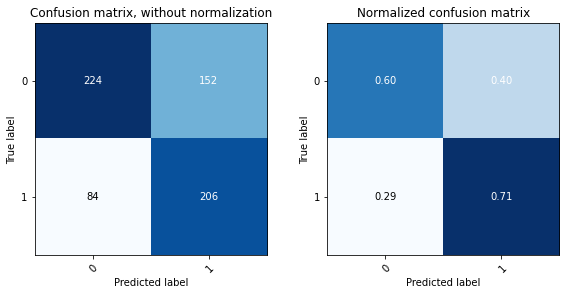

In [69]:
def model_2(embed_matrix):
    print(embed_matrix.shape[0])
    print(embed_matrix.shape[1])
    """
    Extends model_1 with a glove embedding
    """
    model = Sequential()
    model.add(Embedding(input_dim = embed_matrix.shape[0]+1, output_dim = embed_matrix.shape[1], input_length = MAX_SEQ_LEN,  trainable=False))
    model.add(LSTM(128))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


m2 = train(lambda : model_2(glove_embed_matrix), 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           checkpoint_path='model_2.h5',
           class_weights={i : cws[i] for i in range(2)},
           fit_verbose = 2,
           print_summary = False
          )

In [70]:
def model_3(embed_matrix):
    """
    Extends model 1c, will be trained with multiple embeddings
    """
    model = Sequential()
    model.add(Embedding(input_dim = embed_matrix.shape[0]+1, output_dim = embed_matrix.shape[1], input_length = MAX_SEQ_LEN,  trainable=False))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)))
    model.add(Conv1D(64, 4))
    model.add(GlobalMaxPool1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


Epoch 00001: val_accuracy improved from -inf to 0.63063, saving model to model.hdf5

Epoch 00002: val_accuracy did not improve from 0.63063

Epoch 00003: val_accuracy improved from 0.63063 to 0.69520, saving model to model.hdf5

Epoch 00004: val_accuracy did not improve from 0.69520

Epoch 00005: val_accuracy improved from 0.69520 to 0.71171, saving model to model.hdf5

Epoch 00006: val_accuracy did not improve from 0.71171

Epoch 00007: val_accuracy did not improve from 0.71171


****************************


Loading Best Model...
21/21 [==============================] - 0s 12ms/step
Validation Loss: 0.583285242889647
Test Accuracy 0.7117117117117117
F1 Score: 0.7118226680288535
              precision    recall  f1-score   support

           0       0.75      0.74      0.74       376
           1       0.67      0.67      0.67       290

    accuracy                           0.71       666
   macro avg       0.71      0.71      0.71       666
weighted avg       0.71      0.71    

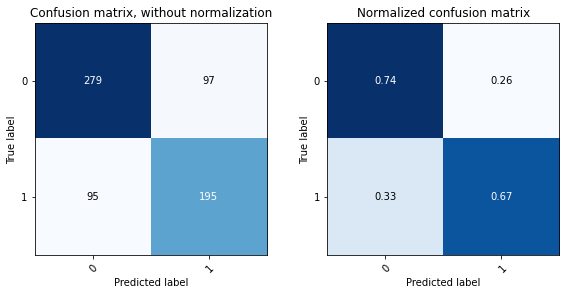


++++++++++++++++++++++++++++++++++++++++++

Model 3 w/ Twitter Embedding

Epoch 00001: val_accuracy improved from -inf to 0.55255, saving model to model.hdf5

Epoch 00002: val_accuracy did not improve from 0.55255

Epoch 00003: val_accuracy improved from 0.55255 to 0.66366, saving model to model.hdf5

Epoch 00004: val_accuracy improved from 0.66366 to 0.68619, saving model to model.hdf5

Epoch 00005: val_accuracy improved from 0.68619 to 0.69369, saving model to model.hdf5

Epoch 00006: val_accuracy did not improve from 0.69369

Epoch 00007: val_accuracy did not improve from 0.69369


****************************


Loading Best Model...
21/21 [==============================] - 0s 11ms/step
Validation Loss: 0.5799949386411601
Test Accuracy 0.6936936936936937
F1 Score: 0.6946750783004367
              precision    recall  f1-score   support

           0       0.74      0.70      0.72       376
           1       0.64      0.69      0.66       290

    accuracy                          

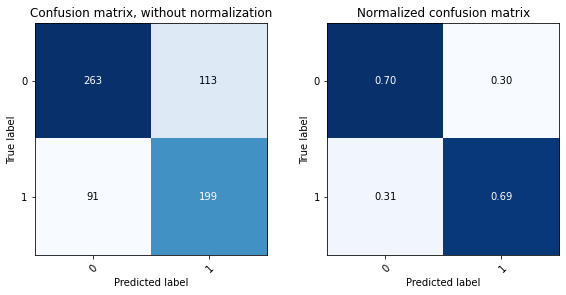


++++++++++++++++++++++++++++++++++++++++++

Model 3 w/ Stacked Embedding

Epoch 00001: val_accuracy improved from -inf to 0.66667, saving model to model.hdf5

Epoch 00002: val_accuracy did not improve from 0.66667

Epoch 00003: val_accuracy improved from 0.66667 to 0.71622, saving model to model.hdf5

Epoch 00004: val_accuracy did not improve from 0.71622

Epoch 00005: val_accuracy improved from 0.71622 to 0.73423, saving model to model.hdf5

Epoch 00006: val_accuracy did not improve from 0.73423

Epoch 00007: val_accuracy did not improve from 0.73423


****************************


Loading Best Model...
21/21 [==============================] - 0s 20ms/step
Validation Loss: 0.5483771948837437
Test Accuracy 0.7342342342342343
F1 Score: 0.7352847630292051
              precision    recall  f1-score   support

           0       0.81      0.69      0.75       376
           1       0.66      0.79      0.72       290

    accuracy                           0.73       666
   macro avg    

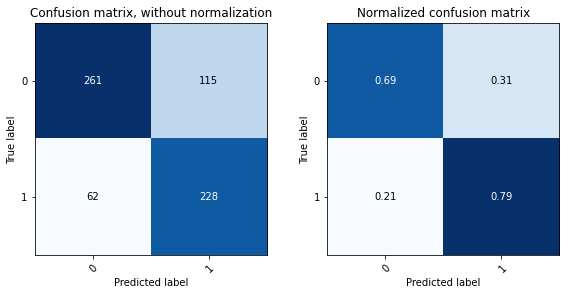

In [71]:
_ = train(lambda : model_3(glove_embed_matrix), 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           class_weights={i : cws[i] for i in range(2)},
           fit_verbose=0,
           print_summary = False

          )

print("\n++++++++++++++++++++++++++++++++++++++++++\n")

print("Model 3 w/ Twitter Embedding")
_ = train(lambda : model_3(twitter_embed_matrix), 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           class_weights={i : cws[i] for i in range(2)},
           fit_verbose=0,
           print_summary = False

          )

print("\n++++++++++++++++++++++++++++++++++++++++++\n")

print("Model 3 w/ Stacked Embedding")
_ = train(lambda : model_3(np.hstack((twitter_embed_matrix, glove_embed_matrix))), 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           class_weights={i : cws[i] for i in range(2)},
           fit_verbose=0,
           print_summary = False

          )